In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

# Problem Description

![](https://objects-us-east-1.dream.io/mae223/2019f/mae223-l17-example-fig.png)

# Generalized coordinates

In [2]:
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')

# Generalized speeds

In [3]:
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

# Specified Inputs

In [4]:
F, T = me.dynamicsymbols('F, T')

# Constants

In [5]:
k, c, ma, mb, mc, IB_bo, l, kT, g = sm.symbols('k, c, m_a, m_b, m_c, I_{B_bo}, l, k_T, g')
k, c, ma, mb, mc, IB_bo, l, kT, g

# Reference Frames

In [6]:
N = me.ReferenceFrame('N')

In [7]:
B = N.orientnew('B', 'Axis', (q2, N.z))

In [8]:
C = B.orientnew('C', 'Axis', (q3, N.z))

# Points

In [9]:
O = me.Point('O')

In [10]:
Pab = O.locatenew('P_{ab}', q1 * N.x)

In [11]:
Bo = Pab.locatenew('B_o', - 2 * l / 3 * B.y)

In [12]:
Pbc = Pab.locatenew('P_{bc}', -l * B.y)

In [13]:
Pc = Pbc.locatenew('P_c', -l * C.y)

In [14]:
Pc.pos_from(O)

# Linear Velocities

In [15]:
Pab.set_vel(N, Pab.pos_from(O).dt(N))
Pab.vel(N)

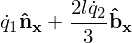

In [16]:
Bo.v2pt_theory(Pab, N, B)

In [17]:
Pbc.v2pt_theory(Pab, N, B)

In [18]:
Pc.v2pt_theory(Pbc, N, C)

# Kinematic Differential Equations

In [19]:
u1_eq = sm.Eq(u1, Pab.vel(N).dot(N.x))
u2_eq = sm.Eq(u2, Bo.vel(N).dot(B.x))
u3_eq = sm.Eq(u3, C.ang_vel_in(B).dot(B.z))

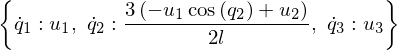

In [20]:
qdots = sm.solve([u1_eq, u2_eq, u3_eq], q1.diff(), q2.diff(), q3.diff())
qdots

Substitute expressions for the $\dot{q}$'s.

In [21]:
Pab.set_vel(N, Pab.vel(N).subs(qdots).simplify())
Pab.vel(N)

In [22]:
Bo.set_vel(N, Bo.vel(N).subs(qdots).express(B).simplify())
Bo.vel(N)

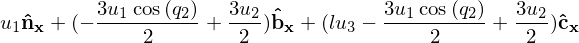

In [23]:
Pc.set_vel(N, Pc.vel(N).subs(qdots).simplify())
Pc.vel(N)

# Angular Velocities

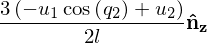

In [24]:
B.set_ang_vel(N, B.ang_vel_in(N).subs(qdots).simplify())
B.ang_vel_in(N)

In [25]:
C.set_ang_vel(B, u3 * N.z)

# Partial Velocities

Each partial velocity can be calculated manually like so:

In [26]:
Pab.vel(N).diff(u1, N)

Or you can use this convenience function:

In [27]:
Pab.partial_velocity(N, u1)

All partial velocities can be calculated at once with:

In [28]:
Pab.partial_velocity(N, u1, u2, u3)

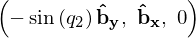

In [29]:
Bo.partial_velocity(N, u1, u2, u3)

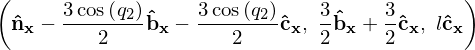

In [30]:
Pc.partial_velocity(N, u1, u2, u3)

This also works for angular partial velocities:

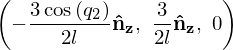

In [31]:
B.partial_velocity(N, u1, u2, u3)

The convenience function is doing this behind the scenes:

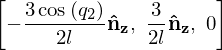

In [32]:
[B.ang_vel_in(N).diff(ur, N) for ur in [u1, u2, u3]]

# Angular Accelerations

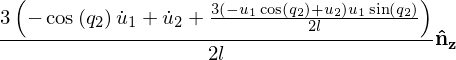

In [33]:
alpha_B_N = B.ang_acc_in(N).subs(qdots)
alpha_B_N

In [34]:
a_Pab_N = Pab.acc(N).subs(qdots)
a_Pab_N

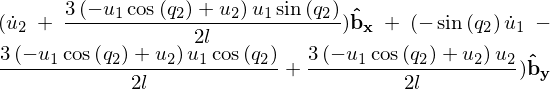

In [35]:
a_Bo_N = Bo.acc(N).express(B).subs(qdots)
a_Bo_N

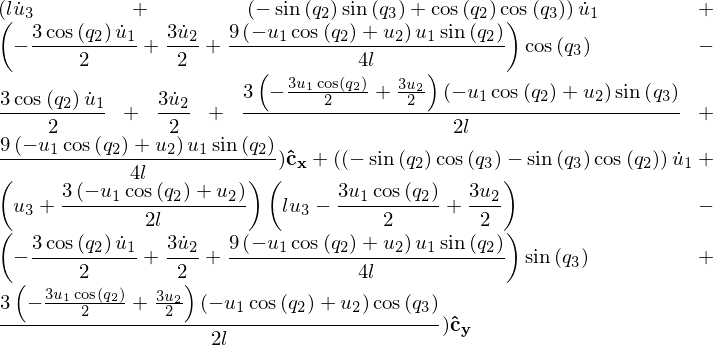

In [36]:
a_Pc_N = Pc.acc(N).express(C).subs(qdots)
a_Pc_N

# Mass and Inertia

In [37]:
ma, mc

In [38]:
IB = me.inertia(B, 0, 0, IB_bo)
IB

# Loads (forces and torques)

In [39]:
Rab = (F - k*q1 - c*qdots[q1.diff()]) * N.x
Rab

In [40]:
Rbo = -(mb*g)*N.y
Rbo

In [41]:
Rc = -(mc*g)*N.y
Rc

In [42]:
TB = (T + kT*q3)*N.z
TB

# Generalizd Active Forces

In [43]:
Pab.partial_velocity(N, u1).dot(Rab)

In [44]:
Pab.partial_velocity(N, u2).dot(Rab)

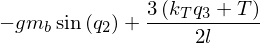

In [45]:
Bo.partial_velocity(N, u2).dot(Rbo) + B.partial_velocity(N, u2).dot(TB)

In [46]:
u = [u1, u2, u3]

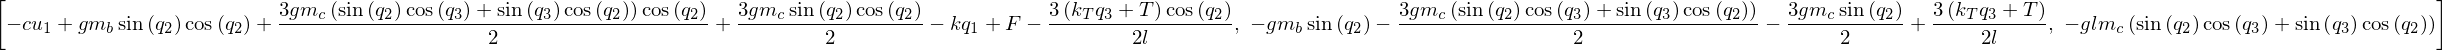

In [47]:
Fr = []

for ur in u:
    Fr.append(Pab.partial_velocity(N, ur).dot(Rab) + # particle
              Pc.partial_velocity(N, ur).dot(Rc) + # particle
              Bo.partial_velocity(N, ur).dot(Rbo) + B.partial_velocity(N, ur).dot(TB)) # rigid body
    
Fr

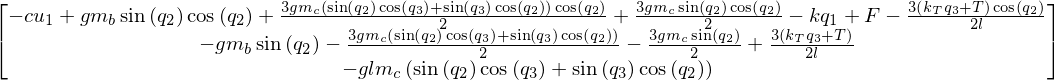

In [48]:
Fr = sm.Matrix(Fr)
Fr

# Generalized Inertia Forces

In [49]:
Frstar = []

for ur in u:
    Frstar.append(Pab.partial_velocity(N, ur).dot(-ma*a_Pab_N) +
                  Pc.partial_velocity(N, ur).dot(-mc*a_Pc_N) +
                  Bo.partial_velocity(N, ur).dot(-mb*a_Bo_N) +
                  B.partial_velocity(N, ur).dot(-alpha_B_N.dot(IB) +
                                                B.ang_vel_in(N).cross(IB.dot(B.ang_vel_in(N)))))
    
Frstar = sm.Matrix(Frstar)

In [50]:
Frstar = Frstar

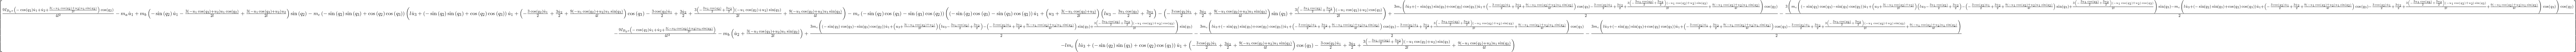

In [51]:
Frstar

In [52]:
f = Fr + Frstar

In [53]:
me.find_dynamicsymbols(f)

In [54]:
f.free_symbols

# Linearize

Create a state vector with all of the u's and q's.

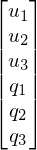

In [55]:
x = sm.Matrix([u1, u2, u3, q1, q2, q3])
x

For this model, an equilibrium point happens to be when $\bar{x}=0$, so create that vector:

In [56]:
xeq = sm.zeros(6, 1)
xeq

Make sure the dynamical equations are functions of the correct variables:

In [57]:
me.find_dynamicsymbols(f), f.shape

Express the kinematical equations in the form $\bar{g}(\bar{x},\dot{\bar{x}}, t)=0$

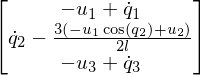

In [58]:
g = sm.Matrix([q1.diff() - u1,
               q2.diff() - qdots[q2.diff()],
               q3.diff() - u3])
g

Form the vector function of both the dynamical and kinematical equations:

In [59]:
h = f.col_join(g)

For a holomic system h should be 2n in length: 

In [60]:
h.shape

This vector is just there to help us avoid an incorrect substitution in the following steps. We don't want to sub in for things inside derivatives.

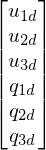

In [61]:
q1d, q2d, q3d, u1d, u2d, u3d = me.dynamicsymbols('q_{1d}, q_{2d}, q_{3d}, u_{1d}, u_{2d}, u_{3d}')
xd = sm.Matrix([u1d, u2d, u3d, q1d, q2d, q3d])
xd

In [62]:
{k: v for k, v in zip(x.diff(), xd)}

In [63]:
h = h.subs({k: v for k, v in zip(x.diff(), xd)})

In [64]:
me.find_dynamicsymbols(h)

In [65]:
xeq_sub = {k: v for k, v in zip(x, xeq)}
xeq_sub

Here is the linearization using the first two terms of the Taylor Series

$\bar{h}_{lin} = \bar{h}(\bar{x}_{eq}) + J_h(\bar{x}_{eq})(\bar{x} - \bar{x}_{eq})$

In [66]:
h_lin = h.subs(xeq_sub) + h.jacobian(x).subs(xeq_sub)*(x - xeq)

In [67]:
h_lin.simplify()

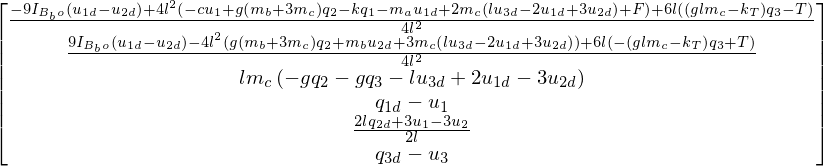

In [68]:
h_lin

Now, solve for $\dot{\bar{x}}$ by forming $\mathbf{M}\dot{\bar{x}} = \mathbf{G}$

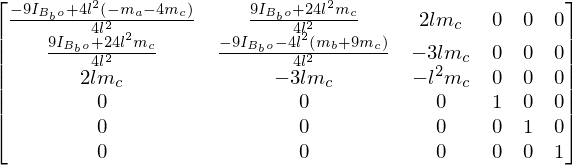

In [69]:
M = h_lin.jacobian(xd)
M

In [70]:
xdot = M.LUsolve(-(h_lin - M*xd))
xdot.simplify()

You can put it into state space form now: $\dot{\bar{x}}=\mathbf{A}\bar{x}+\mathbf{B}\bar{u}$

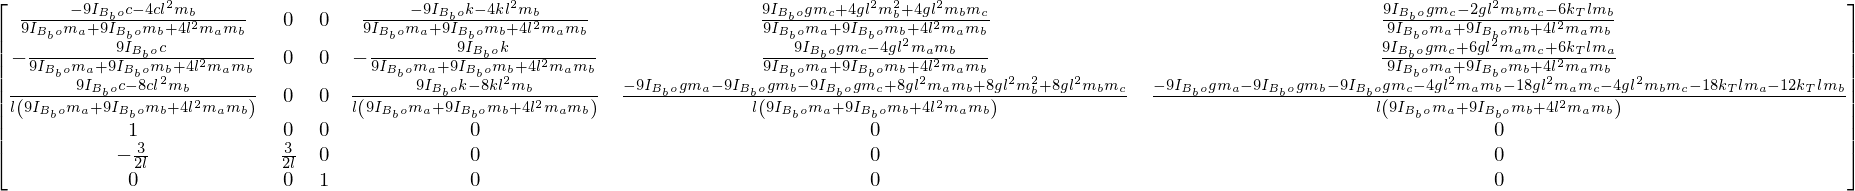

In [71]:
A = xdot.jacobian(x)
A

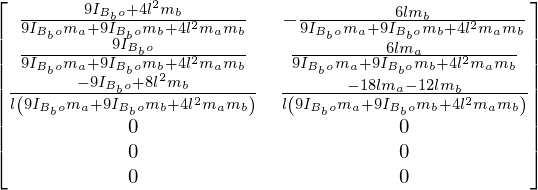

In [72]:
B = xdot.jacobian([F, T])
B